In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from optuna.exceptions import ExperimentalWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ExperimentalWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import numpy as np
import pandas as pd
import time

from pyspark.sql import SparkSession
from replay.utils.session_handler import get_spark_session, State

from replay.models import UCB, Wilson, RandomRec, LinUCB
from replay.experimental.scenarios.movielens_wrapper.replay_offline import OBPOfflinePolicyLearner
from replay.experimental.scenarios.movielens_wrapper.MIPS import MIPS
from replay.experimental.scenarios.movielens_wrapper.dataset import MovielensBanditDataset
from replay.experimental.scenarios.movielens_wrapper.utils import get_est_rewards_by_reg, bandit_subset
from replay.utils.spark_utils import convert2spark

import obp
from obp.dataset import OpenBanditDataset
from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust,
    SelfNormalizedInverseProbabilityWeighting,
    SelfNormalizedDoublyRobust,
    MarginalizedInverseProbabilityWeighting,
)

'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


In [4]:
spark = State(get_spark_session()).session
spark.sparkContext.setLogLevel('ERROR')

24/09/11 00:15:35 WARN Utils: Your hostname, sudakovcom-MS-7D48 resolves to a loopback address: 127.0.1.1; using 10.255.173.26 instead (on interface enp3s0)
24/09/11 00:15:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/11 00:15:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/11 00:15:35 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


Lets define OpenBanditDataset class with random policy. For the purpose of demonstration we won't use the whole dataset but only subset of size 10000.

In [5]:
from rs_datasets import MovieLens

data = MovieLens("1m")
data.info()

ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [6]:
dataset = MovielensBanditDataset(data)

11-Sep-24 00:15:38, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
11-Sep-24 00:15:44, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
11-Sep-24 00:15:45, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


fit started
predict started


100%|██████████| 1000209/1000209 [01:35<00:00, 10523.92it/s]


In [7]:
dataset.item_features.show(5)

+--------+-------+------+-----------+----------+-----+---------+---------+-----+---------+-------+------+-------+-------+--------+---+------+-------+------+
|item_idx|Mystery|Action|Documentary|Children's|Drama|Adventure|Film-Noir|Crime|Animation|Fantasy|Comedy|Western|Romance|Thriller|War|Sci-Fi|Musical|Horror|
+--------+-------+------+-----------+----------+-----+---------+---------+-----+---------+-------+------+-------+-------+--------+---+------+-------+------+
|      29|      0|     0|          0|         1|    0|        0|        0|    0|        1|      0|     1|      0|      0|       0|  0|     0|      0|     0|
|     393|      0|     0|          0|         1|    0|        1|        0|    0|        0|      1|     0|      0|      0|       0|  0|     0|      0|     0|
|     648|      0|     0|          0|         0|    0|        0|        0|    0|        0|      0|     1|      0|      1|       0|  0|     0|      0|     0|
|    1574|      0|     0|          0|         0|    1|    

In [8]:
dataset.user_features.show(5)

+--------+--------------+--------------+--------------+--------------+------------+--------+--------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|user_idx|agegroup_20-29|agegroup_30-39|agegroup_40-49|agegroup_51-60|agegroup_<20|gender_F|gender_M|occupation_0|occupation_1|occupation_2|occupation_3|occupation_4|occupation_5|occupation_6|occupation_7|occupation_8|occupation_9|occupation_10|occupation_11|occupation_12|occupation_13|occupation_14|occupation_15|occupation_16|occupation_17|occupation_18|occupation_19|occupation_20|
+--------+--------------+--------------+--------------+--------------+------------+--------+--------+------------+------------+------------+------------+------------+------------+------------+------------+------------+----------

In [9]:
dataset.log.show(5)

+--------+--------+---------+-------------------+
|user_idx|item_idx|relevance|          timestamp|
+--------+--------+---------+-------------------+
|    4131|      43|        1|2001-01-01 01:12:40|
|    4131|     585|        1|2001-01-01 01:35:09|
|    4131|     461|        1|2001-01-01 01:32:48|
|    4131|     105|        1|2001-01-01 01:04:35|
|    4131|      47|        1|2001-01-07 02:38:11|
+--------+--------+---------+-------------------+
only showing top 5 rows



In [10]:
dataset.context

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [11]:
dataset.action_context

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [12]:
bandit_feedback_train, bandit_feedback_test = dataset.obtain_batch_bandit_feedback(test_size=0.3, is_timeseries_split=True)

print(bandit_feedback_train["n_rounds"])
print(bandit_feedback_test["n_rounds"])

100%|██████████| 111054/111054 [00:11<00:00, 9761.51it/s] 


700144
111054


In [13]:
bandit_feedback_train.keys()

dict_keys(['log', 'item_features', 'user_features', 'n_rounds', 'n_actions', 'action', 'position', 'reward', 'pscore', 'context', 'action_context'])

The keys of the dictionary are as follows.
- n_rounds: number of rounds, data size of the logged bandit data;
- n_actions: number of actions $|\mathcal{A}|$;
- action: action variables sampled by the behavior policy;
- position: positions where actions are recommended, there are three positions in the ZOZOTOWN rec interface;
- reward: binary reward variables, click indicators;
- pscore: action choice probabilities by the behavior policy, propensity scores;
- context: context vectors such as user-related features and user-item affinity scores;
- action_context: item-related context vectors

In [14]:
#Define replay model
model_1 = UCB(exploration_coef = 2.0, sample = True, seed = 123)
model_2 = LinUCB(eps = -10.0, alpha = 1.0, regr_type = 'disjoint')
model_3 = RandomRec(seed=42)

#Define learner which connects OBP data format with replay
learner_1 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_1,
                                    len_list=dataset.len_list,) #len_list is the number of predicted items per user
learner_2 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_2,
                                    len_list=dataset.len_list,) #len_list is the number of predicted items per user

learner_3 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_3,
                                    len_list=dataset.len_list,)

**RePlayOfflinePolicyLearner** has the following methods
- *fit(action, reward, timestamp, context, action_context)*;
- *predict(n_rounds, context)* (context can be None thus n_rounds is **required**);
- *optimize(bandit_feedback, val_size, param_borders, criterion, budget, new_study)*

In [15]:
bandit_feedback_train['log'].show(3)

+--------+--------+---------+-------------------+
|user_idx|item_idx|relevance|          timestamp|
+--------+--------+---------+-------------------+
|    3021|     366|        1|2000-11-22 06:03:07|
|    3021|      37|        1|2000-11-22 06:03:36|
|    3021|       6|        1|2000-11-22 06:04:11|
+--------+--------+---------+-------------------+
only showing top 3 rows



In [16]:
#Fit replay model inside our learner
learner_1.fit(bandit_feedback_train)
learner_2.fit(bandit_feedback_train)
learner_3.fit(bandit_feedback_train)

In [17]:
estimated_rewards_by_reg_model = get_est_rewards_by_reg(dataset.n_actions,
                                                        dataset.len_list,
                                                        bandit_feedback_train,
                                                        bandit_feedback_test)

When we get distribution over actions - we can run any evaluation procedure from the OBP. Here we use three estimators
- *IPW*: Average rewards with importance weights
- *DM*: Average predicted rewards using the classifier
- *DR*: Combination of the above methods with zero bias and lower variance

Also, we can construct confidence intervals for each of these methods.

In [18]:
def get_dist(learner):
    all_action_dist = np.zeros((bandit_feedback_test["n_rounds"], dataset.n_actions, dataset.len_list))
    if isinstance(learner.replay_model, (LinUCB)):
        log_distinct = bandit_feedback_test['log'].toPandas().drop_duplicates(subset=["user_idx"], keep='first')
        users_all = bandit_feedback_test['log'].toPandas()['user_idx'].tolist()
        batch_size = 100
        num_batchs = bandit_feedback_test['n_rounds'] // batch_size + 1
        for i in range(num_batchs):
            j = min((i+1)*batch_size, bandit_feedback_test["n_rounds"])
            log_subset = log_distinct.iloc[i*batch_size: j]
            n_rounds = log_subset.shape[0]
            if n_rounds == 0:
                break
            action_dist = learner.predict(n_rounds, convert2spark(log_subset).select('user_idx'))

            users_distinct = log_subset['user_idx'].tolist()

            user2ind = {}
            for i in range(n_rounds):
                user2ind[users_distinct[i]] = i

            for i in range(bandit_feedback_test["n_rounds"]):
                if users_all[i] in users_distinct:
                    all_action_dist[i] = action_dist[user2ind[users_all[i]]]

    else:
        batch_size = 300
        num_batchs = bandit_feedback_test["n_rounds"] // batch_size + 1
        for i in range(num_batchs):
            j = min((i+1)*batch_size, bandit_feedback_test["n_rounds"])
            bandit_feedback_subset = bandit_subset([i*batch_size, j], bandit_feedback_test) #The first parameter is a slice of subset [a, b]
            print(type(bandit_feedback_subset["log"].select('user_idx')))
            print(bandit_feedback_subset["log"].select('user_idx').count())
            action_dist = learner.predict(bandit_feedback_subset["n_rounds"], bandit_feedback_subset["log"].select('user_idx'))
            all_action_dist[i*batch_size:j, :, :] = action_dist
    return all_action_dist

In [19]:
#Predict distribution over actions: shape (n_rounds, n_actions, len_list)
import time
# start = time.time()
# learner_action_dist_1 = get_dist(learner_1)
# print(time.time() - start)

start = time.time()
learner_action_dist_2 = get_dist(learner_2)
print(time.time() - start)

# start = time.time()
# learner_action_dist_3 = get_dist(learner_3)
# print(time.time() - start)

5.638145446777344


In [20]:
def run_exp(learner_action_dist):
    Vs = []
    CIs = []

    # for n_size in [50000, 100000, 200000, 300000, bandit_feedback_test["n_rounds"]]:
    for n_size in [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 11000, bandit_feedback_test["n_rounds"]]:
    # for n_size in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, bandit_feedback_test["n_rounds"]]:
        start = time.time()
        bandit_feedback_subset = bandit_subset([0, n_size], bandit_feedback_test) #The first parameter is a slice of subset [a, b]

        ope = OffPolicyEvaluation(
            bandit_feedback=bandit_feedback_subset,
            ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), SelfNormalizedDoublyRobust(),
                            SelfNormalizedInverseProbabilityWeighting(),]
        )

        estimated_rewards_by_reg_model_subset = estimated_rewards_by_reg_model[0: n_size, :, :]
        
        action_dist = learner_action_dist[:n_size, :, :]
        estimated_policy_value = ope.estimate_policy_values(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset,
        )

        estimated_ci = ope.estimate_intervals(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset,
            n_bootstrap_samples=10000,
            random_state=12345,)
        end = time.time()
        print("n_size =", n_size, "time: ", end-start)
        Vs.append(estimated_policy_value)
        CIs.append(estimated_ci)
    return(Vs, CIs)

In [108]:
Vs_1, CIs_1 = run_exp(learner_action_dist_1)

n_size = 1000 time:  0.640376091003418
n_size = 2000 time:  0.8903183937072754
n_size = 3000 time:  1.6063532829284668
n_size = 4000 time:  1.3796043395996094
n_size = 5000 time:  3.2117066383361816
n_size = 6000 time:  2.8516502380371094
n_size = 7000 time:  2.6219584941864014
n_size = 8000 time:  2.3043384552001953
n_size = 9000 time:  6.107375860214233
n_size = 10000 time:  5.804219961166382
n_size = 11000 time:  5.526087045669556
n_size = 12000 time:  5.124424934387207
n_size = 13000 time:  4.878782510757446
n_size = 14000 time:  4.761214733123779
n_size = 15000 time:  4.451655626296997
n_size = 15416 time:  4.248946666717529


In [21]:
Vs_2, CIs_2 = run_exp(learner_action_dist_2)

n_size = 1000 time:  0.6669590473175049
n_size = 2000 time:  0.8762938976287842
n_size = 3000 time:  1.5859041213989258
n_size = 4000 time:  1.3473727703094482
n_size = 5000 time:  3.1947824954986572
n_size = 6000 time:  2.8104772567749023
n_size = 7000 time:  2.531193494796753
n_size = 8000 time:  2.3550872802734375
n_size = 9000 time:  6.223558187484741
n_size = 10000 time:  5.808182716369629
n_size = 11000 time:  5.517534017562866
n_size = 12000 time:  5.365692377090454
n_size = 13000 time:  5.054710865020752
n_size = 14000 time:  4.683707237243652
n_size = 15000 time:  4.4901251792907715


In [110]:
Vs_3, CIs_3 = run_exp(learner_action_dist_3)

n_size = 1000 time:  0.6280803680419922
n_size = 2000 time:  0.878864049911499
n_size = 3000 time:  1.625772476196289
n_size = 4000 time:  1.3177833557128906
n_size = 5000 time:  3.163087844848633
n_size = 6000 time:  2.817145824432373
n_size = 7000 time:  2.528770923614502
n_size = 8000 time:  2.282597541809082
n_size = 9000 time:  5.884617567062378
n_size = 10000 time:  5.6093971729278564
n_size = 11000 time:  5.300260543823242
n_size = 12000 time:  5.068619251251221
n_size = 13000 time:  4.79378867149353
n_size = 14000 time:  4.537503004074097
n_size = 15000 time:  4.256000995635986
n_size = 15416 time:  4.165140151977539


In [52]:
import matplotlib.pyplot as plt
def plot_disjoint_res(Vs, CIs, model): 
    fig, ax = plt.subplots(4, figsize=(10, 10))

    # x = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, bandit_feedback_test["n_rounds"]]
    x = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, bandit_feedback_test["n_rounds"]]
    colors = ['b', 'r', 'g', 'y', 'k']
    i = 0
    for name in ['ipw', 'dm', 'sndr', 'snipw']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax[i].plot(x, y_est, '-', label=name, color = colors[i])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[i])
        #ax.plot(x, y, 'o', color='tab:brown')
        i=i+1
    fig.suptitle("OPE for " + model, fontsize=16)
    fig.legend()

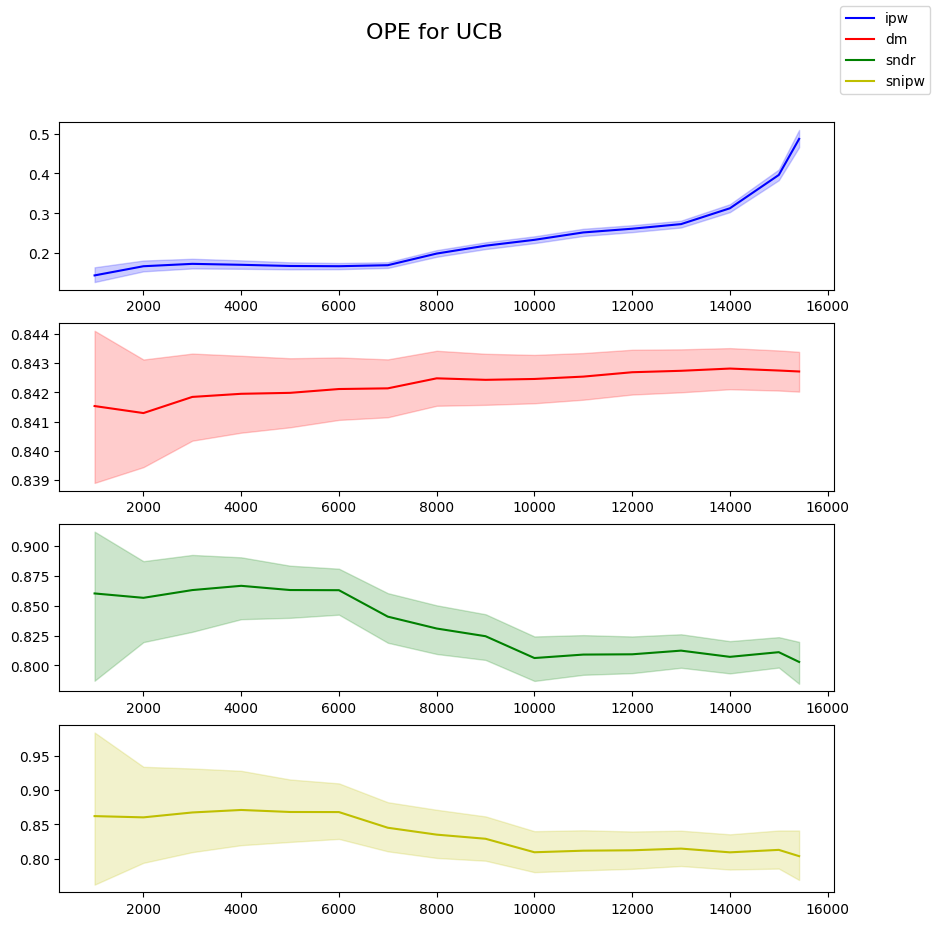

In [112]:
plot_disjoint_res(Vs_1, CIs_1, 'UCB')

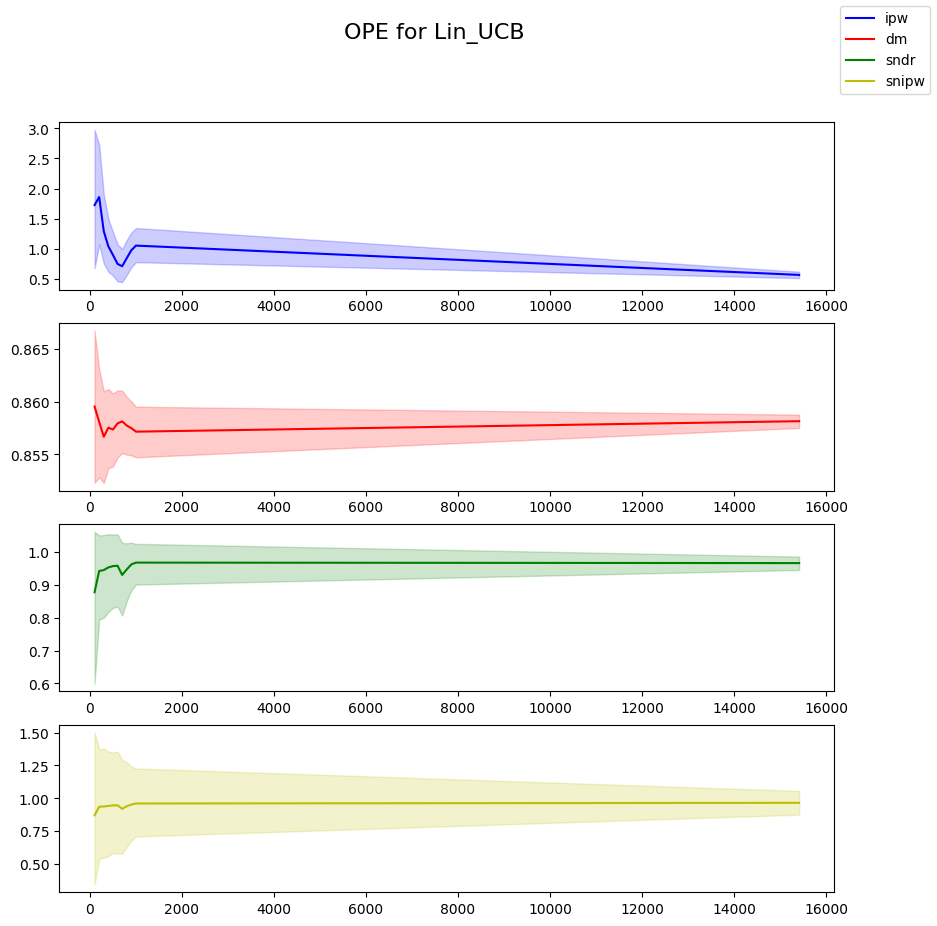

In [53]:
plot_disjoint_res(Vs_2, CIs_2, 'Lin_UCB')

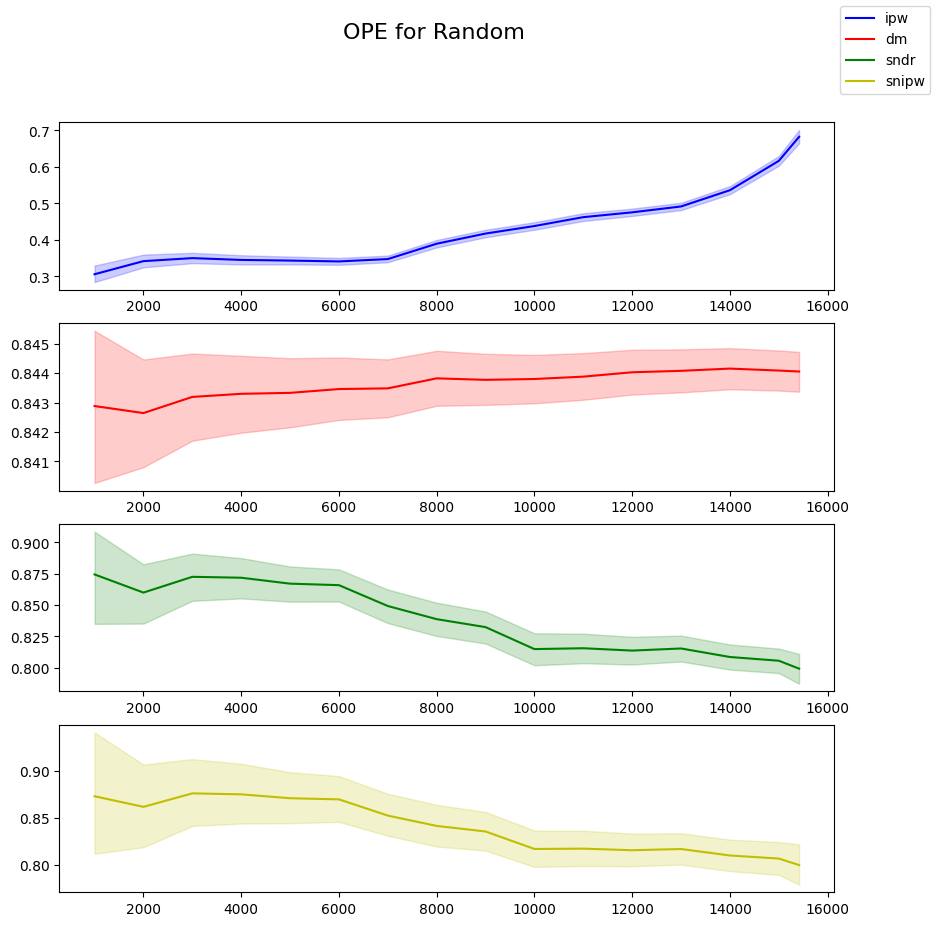

In [114]:
plot_disjoint_res(Vs_3, CIs_3, 'Random')

In [115]:
out_str = f"Scores for UCB true"
for key, val in Vs_1[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for UCB true ipw : 486.625, dm : 842.712, sndr : 802.881, snipw : 803.491


In [116]:
out_str = f"Scores for Lin_UCB true"
for key, val in Vs_2[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for Lin_UCB true ipw : 563.735, dm : 858.240, sndr : 959.732, snipw : 959.274


In [117]:
out_str = f"Scores for random true"
for key, val in Vs_3[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for random true ipw : 681.987, dm : 844.054, sndr : 799.250, snipw : 799.607


In [118]:
print("USB all")
print(Vs_1)

USB all
[{'ipw': 0.14427699622396897, 'dm': 0.8415318589998122, 'sndr': 0.8603873579703951, 'snipw': 0.8625992688369207}, {'ipw': 0.16735014668619647, 'dm': 0.8412699454387832, 'sndr': 0.8567465958521382, 'snipw': 0.8609213678080987}, {'ipw': 0.17328195835993054, 'dm': 0.8418264015533786, 'sndr': 0.8631866482268167, 'snipw': 0.8678417569149814}, {'ipw': 0.17086443258399572, 'dm': 0.8419325470392535, 'sndr': 0.8666857803046191, 'snipw': 0.8712421684119649}, {'ipw': 0.16791621422344077, 'dm': 0.8419746647838936, 'sndr': 0.8631226324352766, 'snipw': 0.8682951774620493}, {'ipw': 0.16730175243308204, 'dm': 0.8421096319687412, 'sndr': 0.8629957666262109, 'snipw': 0.8680378240142809}, {'ipw': 0.16981328276141078, 'dm': 0.8421327957198573, 'sndr': 0.8408106961017443, 'snipw': 0.8451432188467963}, {'ipw': 0.19902847916112285, 'dm': 0.8424749282313235, 'sndr': 0.8309093461208507, 'snipw': 0.8351228592637504}, {'ipw': 0.21870487575413006, 'dm': 0.8424280223876182, 'sndr': 0.8243642644413524, 'sni

In [119]:
print("Lin USB all")
print(Vs_2)

Lin USB all
[{'ipw': 1.2177941428604544, 'dm': 0.8572109540644565, 'sndr': 0.9952107312187525, 'snipw': 0.9874356166047846}, {'ipw': 0.8588489778055557, 'dm': 0.8569365668638234, 'sndr': 0.9439899522200946, 'snipw': 0.9420810506161827}, {'ipw': 0.9785429989374455, 'dm': 0.8574310775814499, 'sndr': 0.9398119308555163, 'snipw': 0.9338853893606344}, {'ipw': 1.35962989932773, 'dm': 0.8575272232548927, 'sndr': 0.955065003749741, 'snipw': 0.952334954445247}, {'ipw': 1.2096274309729982, 'dm': 0.8575872708567029, 'sndr': 0.9565792321016514, 'snipw': 0.9541276844993212}, {'ipw': 1.3597480460842413, 'dm': 0.8577162701039874, 'sndr': 0.9574833163175624, 'snipw': 0.9567334896074519}, {'ipw': 1.2058332426462106, 'dm': 0.8577409266623852, 'sndr': 0.9585809669283318, 'snipw': 0.9581201360967917}, {'ipw': 1.0608481211070286, 'dm': 0.8580573526116723, 'sndr': 0.9589762405596017, 'snipw': 0.9583374499919362}, {'ipw': 0.9429761076506922, 'dm': 0.8580077426067372, 'sndr': 0.9589266305546666, 'snipw': 0.95

In [120]:
print("Random all")
print(Vs_3)

Random all
[{'ipw': 0.30573539945335426, 'dm': 0.8428833281123381, 'sndr': 0.8744811820025487, 'snipw': 0.8734853708326712}, {'ipw': 0.34164519573008073, 'dm': 0.8426230890179666, 'sndr': 0.85994696665333, 'snipw': 0.8622599126818221}, {'ipw': 0.34982456904801024, 'dm': 0.8431755257502449, 'sndr': 0.8725303334106502, 'snipw': 0.876375637356204}, {'ipw': 0.3448399786958008, 'dm': 0.8432808166041708, 'sndr': 0.8717741770281913, 'snipw': 0.8752594287084039}, {'ipw': 0.3430637465656898, 'dm': 0.8433226084791491, 'sndr': 0.8670227142332304, 'snipw': 0.8711066800581332}, {'ipw': 0.34070130260493714, 'dm': 0.8434565808590323, 'sndr': 0.865835826329283, 'snipw': 0.8698223429929016}, {'ipw': 0.3471038118962307, 'dm': 0.8434796000254616, 'sndr': 0.8491730219113305, 'snipw': 0.8524603587217685}, {'ipw': 0.3891947908361238, 'dm': 0.8438193698271278, 'sndr': 0.8387285822293472, 'snipw': 0.8414618462667981}, {'ipw': 0.41697885980499366, 'dm': 0.8437726543553717, 'sndr': 0.8323143170001202, 'snipw': 

In [121]:
print("Estimated confidence intervals UCB:")
print(pd.DataFrame(CIs_1[-1]).to_string())
print("Estimated confidence intervals Lin UCB:")
print(pd.DataFrame(CIs_2[-1]).to_string())
print("Estimated confidence intervals Random:")
print(pd.DataFrame(CIs_3[-1]).to_string())

Estimated confidence intervals UCB:
                       ipw        dm      sndr     snipw
mean              0.486808  0.842712  0.802889  0.803793
95.0% CI (lower)  0.465798  0.842023  0.784600  0.769104
95.0% CI (upper)  0.509442  0.843384  0.819705  0.841165
Estimated confidence intervals Lin UCB:
                       ipw        dm      sndr     snipw
mean              0.563901  0.858240  0.959596  0.959556
95.0% CI (lower)  0.510358  0.857611  0.937130  0.868445
95.0% CI (upper)  0.616855  0.858852  0.980249  1.049665
Estimated confidence intervals Random:
                       ipw        dm      sndr     snipw
mean              0.682140  0.844054  0.799272  0.799787
95.0% CI (lower)  0.664306  0.843370  0.787194  0.778877
95.0% CI (upper)  0.701062  0.844722  0.811000  0.821972
